In [2]:
import numpy as np
from pydrake.all import (
    DiagramBuilder,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    SceneGraph,
    Simulator,
    Meshcat,
    StartMeshcat,
    namedview,
)
from pydrake.examples import QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController
import numpy as np

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
from IPython.display import SVG, display
import pydot

def quadrotor_example():
    builder = DiagramBuilder()

    plant = builder.AddSystem(QuadrotorPlant())

    controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    QuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty("/Background", "visible", False)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    diagram = builder.Build()
    display(SVG(pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()

    # Simulate
    for i in range(20):
        context.SetTime(0.0)
        context.SetContinuousState(
            0.5
            * np.random.randn(
                12,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(4.0)

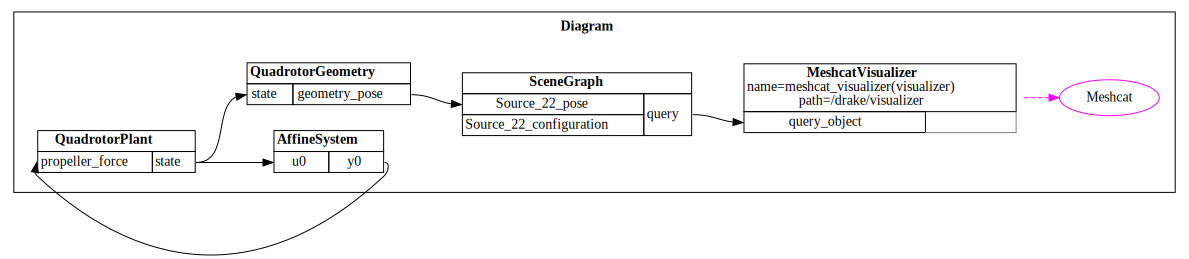

KeyboardInterrupt: 

In [4]:
quadrotor_example()
print("done")

In [107]:
from IPython.display import SVG, display, Markdown

import pydot
from sim.quaternions import QuaternionToRotation, GetAttititudeJacobian, hat

from pydrake.all import Diagram, State, DiscreteValues, ToLatex, FirstOrderTaylorApproximation

def MakeMultibodyQuadrotor(show_diagram = False) -> tuple[Diagram, MultibodyPlant]:
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    plant: MultibodyPlant = builder.AddSystem(MultibodyPlant(0.0))
    parser = Parser(plant)
    (model_instance,) = parser.AddModelsFromUrl(
        "package://drake_models/skydio_2/quadrotor.urdf"
    )
    plant.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    body_index = plant.GetBodyByName("base_link").index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")


    
    builder.ExportOutput(plant.get_state_output_port(), "y")

    diagram: Diagram = builder.Build()

    if show_diagram:
        display(SVG(pydot.graph_from_dot_data(
            diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
    return diagram, plant


quadrotor, mbp = MakeMultibodyQuadrotor()

context = quadrotor.CreateDefaultContext()

StateView = namedview("state", mbp.GetStateNames(False))
nominal_state = StateView.Zero()

nominal_state.base_link_z = 1.0  # height is 1.0m
nominal_state.base_link_qw = 1.0
nominal_state.base_link_qx = 0.0
nominal_state.base_link_qy = 0.0
nominal_state.base_link_qz = 0.0

context.SetContinuousState(nominal_state[:])
mass = mbp.CalcTotalMass(mbp.GetMyContextFromRoot(context))
gravity = mbp.gravity_field().gravity_vector()[2]
nominal_input = [-mass * gravity / 4] * 4
quadrotor.get_input_port().FixValue(context, nominal_input)

MoI = mbp.CalcMassMatrix(mbp.GetMyContextFromRoot(context))


sys =   FirstOrderTaylorApproximation(quadrotor, 
                                    context,
                                    quadrotor.get_input_port().get_index(),
                                    quadrotor.get_output_port().get_index())
# display(Markdown("$A = " + ToLatex(sys.A()) + "$"))
# display(Markdown("$B = " + ToLatex(sys.B()) + "$"))

q0 = context.get_continuous_state_vector().CopyToVector()[:4].reshape((4,1))

# print(mbp.GetStateNames())
# print(mbp.GetStateNames())
# print(f" Mass: {mass}")
# print(f" Moment of Inertia: \n {MoI}")


E = np.zeros((13, 12))
E[:4, :3] = GetAttititudeJacobian(q0)
E[4:, 3:] = np.eye(9)

Ared = E.T @ sys.A() @ E
Bred = E.T @ sys.B()



# diagram, plant = MultibodyQuadrotorExample()
# display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

In [4]:
from pydrake.all import VectorSystem, Variable, SymbolicVectorSystem
import numpy as np

from sim.quaternions import hat, GetLeftMatrix, GetAttititudeJacobian, ParamToQuaternion, QuaternionToParam, QuaternionToRotation

class QuadrotorModel:
    def __init__(self, L, kF, kM, m, J):
        self.L = L
        self.kF = kF
        self.kM = kM
        self.m = m
        self.J = J


        self.J_inv = np.linalg.inv(J)
        self.kF_matrix = np.vstack((np.zeros((2,4)), kF * np.zeros((1, 4))))
        self.kM_matrix = np.array([[   0,   L*kF,   0  , -L*kF],
                                   [-L*kF,    0,   L*kF,   0],
                                   [  kM,   -kM,    kM,   -kM]])
        self._gravity = np.array([0, 0, -9.80665]).reshape((3,1))

        vars = ["x", "y", "z", "qw", "qx", "qy", "qz", "vx", "vy", "vz", "wx", "wy", "wz"]
        state = [Variable(var) for var in vars]
        x, y, z, qw, qx, qy, qz, vx, vy, vz, wx, wy, wz = state
        dynamics = [
            
        ]
        

    def continuous_dynamics(self, x: np.ndarray, u: np.ndarray) -> np.ndarray:
        '''
        :param x: state as [x, y, z, qw, qx, qy, qz, vx, vy, vz, wx, wy, wx]^T
        :param u: action as motor currents
        :return x_dot: state time derivative
        '''

        #State
        r = x[:3]
        q = x[3:7]
        v = x[7:10]
        w = x[10:]

        Q = QuaternionToRotation(q)

        # Time derivatives
        r_dot = Q @ r
        q_dot = 0.5 * GetAttititudeJacobian(q) @ w
        v_dot = Q.T @ self._gravity + 1/self.m * self.kF_matrix @ u - hat(w) @ v
        w_dot = self.J_inv @ (-hat(w) @ self.J @ w + self.kM_matrix @ u) 

        return np.hstack((r_dot, q_dot, v_dot, w_dot))

    def augment_matrix(self, q):
        E = np.zeros((13, 12))
        E[:3, :3] = np.eye(3)
        E[3:7, 3:6] = GetAttititudeJacobian(q)
        E[7:, 6:] = np.eye(6)

        return E 

    def linearize_dynamics(self, reference_state, reference_action):
        q0 = reference_state[3:7]
        #Linearize about reference
        A, B = None, None
        #Compute reduced system
        E = self.augment_matrix(q0)
        A_reduced = E.T @ A @ E
        B_reduced = E.T @ B

        return A_reduced, B_reduced





In [2]:
def MultibodyQuadrotorLQR():
    quadrotor, mbp = MakeMultibodyQuadrotor()
    # We'll use a namedview to make it easier to work with the state.
    StateView = namedview("state", mbp.GetStateNames(False))

    # Create the LQR controller
    context = quadrotor.CreateDefaultContext()
    nominal_state = StateView.Zero()

    nominal_state.base_link_z = 1.0  # height is 1.0m
    nominal_state.base_link_qw = 1.0
    nominal_state.base_link_qx = 0.0
    nominal_state.base_link_qy = 0.0
    nominal_state.base_link_qz = 0.0



    context.SetContinuousState(nominal_state[:])
    mass = mbp.CalcTotalMass(mbp.GetMyContextFromRoot(context))
    gravity = mbp.gravity_field().gravity_vector()[2]
    nominal_input = [-mass * gravity / 4] * 4
    quadrotor.get_input_port().FixValue(context, nominal_input)
    Q = np.diag(np.concatenate(([10] * 7, [1] * 6)))
    R = np.eye(4)
    controller = LinearQuadraticRegulator(quadrotor, context, Q, R)


MultibodyQuadrotorLQR()

NameError: name 'MakeMultibodyQuadrotor' is not defined